In [1]:
import numpy as np
import pandas as pd
import uuid
import ssdeep
from sklearn.cluster import DBSCAN,KMeans
import Levenshtein
from pyjarowinkler import distance
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time

In [2]:
df=pd.read_csv("/Users/n.y.r/Desktop/rental.csv")
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21101 entries, 0 to 21100
Data columns (total 41 columns):
Unnamed: 0                     21101 non-null int64
id                             21101 non-null object
ask                            21101 non-null int64
bedrooms                       21101 non-null int64
title                          21101 non-null object
original_title                 21101 non-null object
address                        0 non-null float64
post_at                        21101 non-null object
created_at                     21101 non-null object
updated_at                     21101 non-null object
source_id                      21101 non-null int64
survey_id                      21101 non-null int64
latitude                       21101 non-null float64
longitude                      21101 non-null float64
post_date                      21101 non-null object
created_date                   21101 non-null object
updated_date                   21101 non-null obj

### PART1. Grouping Location 

In [3]:
df.head(10)

,Unnamed: 0,id,ask,bedrooms,title,original_title,address,post_at,created_at,updated_at,...,one_bedroom,one_bedroom _not_in_range,two_bedroom,two_bedroom _not_in_range,three_bedroom,three_bedroom _not_in_range,four_bedroom,four_bedroom _not_in_range,five_bedroom,five_bedroom _not_in_range
0,55,https://boston.craigslist.org/nos/apa/d/wilmin...,3100,6,SIX BEDROOM HOUSE RENT,6 Bedroom House For Rent,NaN,2020-03-19 18:31:06,2020-04-01 04:03:24,2020-04-01 04:03:24,...,0,0,0,0,0,0,0,0,0,0
1,765,https://boston.craigslist.org/gbs/apa/d/chestn...,5200,6,NO FEE CHESTNUT HILL SIX BEDROOM RENOVATED HO...,No Fee Chestnut Hill 6BR Renovated House - w/3...,NaN,2020-03-27 20:23:00,2020-04-01 04:12:15,2020-04-01 04:12:15,...,0,0,0,0,0,0,0,0,0,0
2,768,https://boston.craigslist.org/gbs/apa/d/newton...,5200,0,STUNNING NINE ROOM SIX BEDROOM THREE BATHROOM...,"Stunning 9 Room, 6 Bed, 3 bathroom house locat...",NaN,2020-03-27 20:04:17,2020-04-01 04:12:15,2020-04-01 04:12:15,...,0,0,0,0,0,0,0,0,0,0
3,900,https://boston.craigslist.org/bmw/apa/d/fitchb...,1800,7,6BRD APARTMENT TEN MO FITCHBURG MA,"6Brd Apartment $1800/mo, FitchBurg MA",NaN,2020-03-06 02:45:28,2020-04-01 04:13:32,2020-04-01 04:13:32,...,0,0,0,0,0,0,0,0,0,0
4,1388,https://boston.craigslist.org/gbs/apa/d/bright...,5400,6,SIX BEDROOM COMMONWEALTH AVENUE TWO BATHROOM ...,"6 Bd on Commonwealth Ave., 2.5 Bath, Dishwashe...",NaN,2020-03-25 23:50:23,2020-04-01 04:17:54,2020-04-01 04:17:54,...,0,0,0,0,0,0,0,0,0,0
5,3126,https://boston.craigslist.org/gbs/apa/d/allsto...,7700,6,ASHFORD STREET SIX BEDROOM TWO BATHROOM PARKI...,"ASHFORD ST 6-Bd, 2-Bath, Parking Included 9/1",NaN,2020-03-18 01:11:32,2020-04-01 04:27:59,2020-04-01 04:27:59,...,0,0,0,0,0,0,0,0,0,0
6,3512,https://boston.craigslist.org/gbs/apa/d/bright...,4895,6,HUGE 6BED 3BATHS COMMONWEALTH AVENUE,"Huge 6bed, 3Baths on Commonwealth Avenue",NaN,2020-03-02 20:54:46,2020-04-01 04:32:20,2020-04-01 04:32:20,...,0,0,0,0,0,0,0,0,0,0
7,3625,https://boston.craigslist.org/gbs/apa/d/medfor...,4500,6,SIX ONE MODERN 6BD TUFTS BUS HARVARD DAVIS TW...,6/1!Modern 6.5BD!Tufts!Bus to Harvard/Davis!2 ...,NaN,2020-03-12 15:23:23,2020-04-01 04:33:21,2020-04-01 04:33:21,...,0,0,0,0,0,0,0,0,0,0
8,3672,https://boston.craigslist.org/gbs/apa/d/cambri...,9800,8,JAW DROPPING EIGHT BEDROOM THREE BATH MEMORIA...,Jaw dropping 8 br 3 bath on Memorial dr near H...,NaN,2020-03-11 18:13:11,2020-04-01 04:34:43,2020-04-01 04:34:43,...,0,0,0,0,0,0,0,0,0,0
9,4046,https://boston.craigslist.org/gbs/apa/d/medfor...,4500,6,MODERN LARGE SIX BEDROOM TWO BATHS W FOUR PAR...,Modern Large 6.5 Bed/2 Baths w/4 Parking near ...,NaN,2020-03-10 12:39:32,2020-04-01 04:37:53,2020-04-01 04:37:53,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X=df.loc[:,['latitude','longitude']]
id_n=200
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X)
id_label=kmeans.labels_
print (id_label)

[ 90 186 186 ...  75   4   4]


In [5]:
centers = kmeans.cluster_centers_
print (centers)
# X.plot.scatter(x = 'latitude', y = 'longitude', c=id_label, s=400, cmap='tab20c',figsize=(25,25))
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.4)

[[-71.11080412  42.31234794]
 [-71.16167633  42.7060479 ]
 [-71.52249958  42.22385625]
 [-70.94757986  42.5431253 ]
 [-71.10349389  42.38240974]
 [-71.04868426  42.17238799]
 [-71.35333475  42.63332527]
 [-71.21162021  42.35225153]
 [-71.06348748  42.34916877]
 [-71.09336722  41.91057504]
 [-73.253997    42.122801  ]
 [-71.476802    42.0746    ]
 [-71.51530525  42.42840625]
 [-70.66795815  42.61685655]
 [-70.8390025   42.76994917]
 [-71.13295184  42.35386527]
 [-71.22282395  42.60112995]
 [-70.68365671  41.96495586]
 [-71.24872238  42.13660564]
 [-71.42814747  42.28797001]
 [-71.15362456  42.41545478]
 [-71.06287597  42.42906781]
 [-70.97641673  42.24057682]
 [-71.7517584   42.5288316 ]
 [-70.84867659  42.12728571]
 [-71.797774    42.24144407]
 [-71.02606772  42.36429696]
 [-70.97231083  41.98904613]
 [-70.87953811  42.55608501]
 [-71.01019534  42.46091155]
 [-71.31565565  41.97728762]
 [-71.10425362  42.780089  ]
 [-71.15027668  42.33907942]
 [-71.37400363  42.45684626]
 [-71.03341236

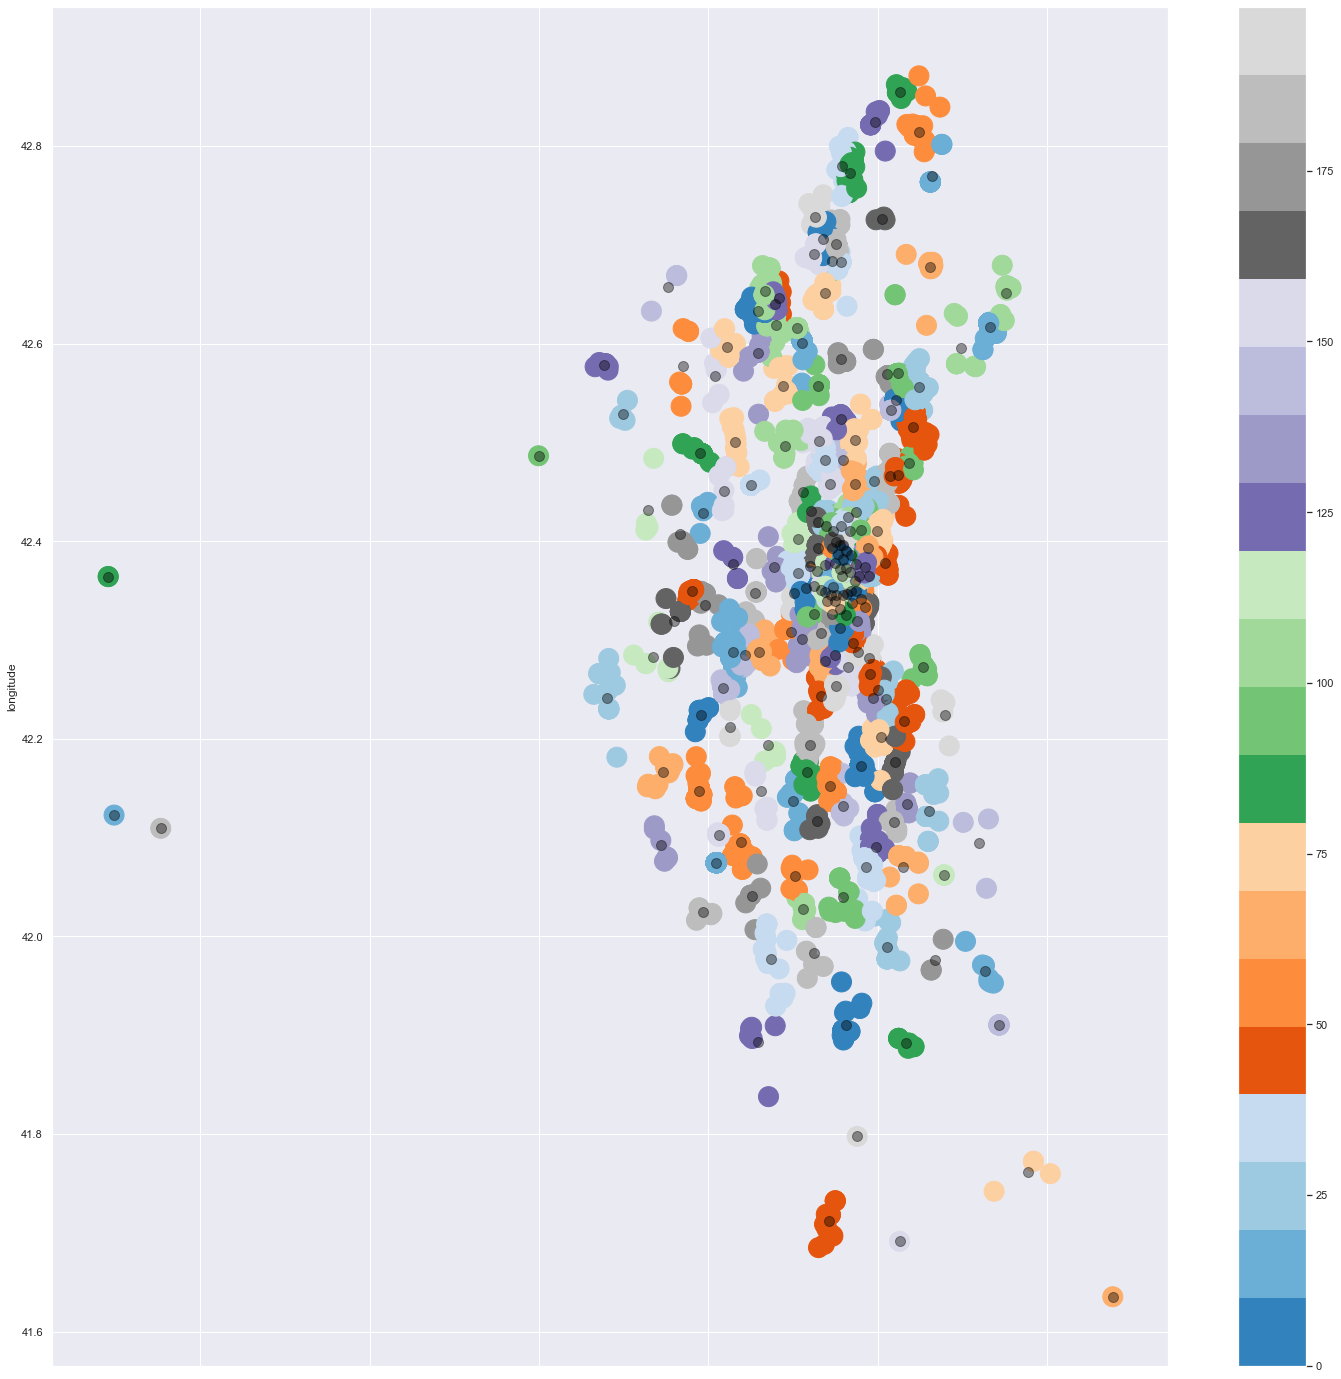

In [6]:
X.plot.scatter(x = 'latitude', y = 'longitude', c=id_label, s=400, cmap='tab20c',figsize=(25,25))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.4)

In [7]:
df['loc_grp']=id_label

In [8]:
print(df['loc_grp'].value_counts().loc[lambda x :x < 2])

195    1
99     1
184    1
159    1
62     1
10     1
Name: loc_grp, dtype: int64


In [9]:
df_clean=df[['id','loc_grp','title']]

In [10]:
df_clean.head(10)

,id,loc_grp,title
0,https://boston.craigslist.org/nos/apa/d/wilmin...,90,SIX BEDROOM HOUSE RENT
1,https://boston.craigslist.org/gbs/apa/d/chestn...,186,NO FEE CHESTNUT HILL SIX BEDROOM RENOVATED HO...
2,https://boston.craigslist.org/gbs/apa/d/newton...,186,STUNNING NINE ROOM SIX BEDROOM THREE BATHROOM...
3,https://boston.craigslist.org/bmw/apa/d/fitchb...,127,6BRD APARTMENT TEN MO FITCHBURG MA
4,https://boston.craigslist.org/gbs/apa/d/bright...,32,SIX BEDROOM COMMONWEALTH AVENUE TWO BATHROOM ...
5,https://boston.craigslist.org/gbs/apa/d/allsto...,15,ASHFORD STREET SIX BEDROOM TWO BATHROOM PARKI...
6,https://boston.craigslist.org/gbs/apa/d/bright...,118,HUGE 6BED 3BATHS COMMONWEALTH AVENUE
7,https://boston.craigslist.org/gbs/apa/d/medfor...,38,SIX ONE MODERN 6BD TUFTS BUS HARVARD DAVIS TW...
8,https://boston.craigslist.org/gbs/apa/d/cambri...,123,JAW DROPPING EIGHT BEDROOM THREE BATH MEMORIA...
9,https://boston.craigslist.org/gbs/apa/d/medfor...,38,MODERN LARGE SIX BEDROOM TWO BATHS W FOUR PAR...


In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21101 entries, 0 to 21100
Data columns (total 3 columns):
id         21101 non-null object
loc_grp    21101 non-null int32
title      21101 non-null object
dtypes: int32(1), object(2)
memory usage: 412.2+ KB


In [12]:
df_num=df_clean[['loc_grp','title']].to_numpy()

In [13]:
print (len(df_num))

21101


In [14]:
df['Duplicate_Info']=' '

In [15]:
df['Same_Info']=' '

### Fuzzywuzzy

In [16]:
df.head(50)

,Unnamed: 0,id,ask,bedrooms,title,original_title,address,post_at,created_at,updated_at,...,two_bedroom _not_in_range,three_bedroom,three_bedroom _not_in_range,four_bedroom,four_bedroom _not_in_range,five_bedroom,five_bedroom _not_in_range,loc_grp,Duplicate_Info,Same_Info
0,55,https://boston.craigslist.org/nos/apa/d/wilmin...,3100,6,SIX BEDROOM HOUSE RENT,6 Bedroom House For Rent,NaN,2020-03-19 18:31:06,2020-04-01 04:03:24,2020-04-01 04:03:24,...,0,0,0,0,0,0,0,90,,
1,765,https://boston.craigslist.org/gbs/apa/d/chestn...,5200,6,NO FEE CHESTNUT HILL SIX BEDROOM RENOVATED HO...,No Fee Chestnut Hill 6BR Renovated House - w/3...,NaN,2020-03-27 20:23:00,2020-04-01 04:12:15,2020-04-01 04:12:15,...,0,0,0,0,0,0,0,186,,
2,768,https://boston.craigslist.org/gbs/apa/d/newton...,5200,0,STUNNING NINE ROOM SIX BEDROOM THREE BATHROOM...,"Stunning 9 Room, 6 Bed, 3 bathroom house locat...",NaN,2020-03-27 20:04:17,2020-04-01 04:12:15,2020-04-01 04:12:15,...,0,0,0,0,0,0,0,186,,
3,900,https://boston.craigslist.org/bmw/apa/d/fitchb...,1800,7,6BRD APARTMENT TEN MO FITCHBURG MA,"6Brd Apartment $1800/mo, FitchBurg MA",NaN,2020-03-06 02:45:28,2020-04-01 04:13:32,2020-04-01 04:13:32,...,0,0,0,0,0,0,0,127,,
4,1388,https://boston.craigslist.org/gbs/apa/d/bright...,5400,6,SIX BEDROOM COMMONWEALTH AVENUE TWO BATHROOM ...,"6 Bd on Commonwealth Ave., 2.5 Bath, Dishwashe...",NaN,2020-03-25 23:50:23,2020-04-01 04:17:54,2020-04-01 04:17:54,...,0,0,0,0,0,0,0,32,,
5,3126,https://boston.craigslist.org/gbs/apa/d/allsto...,7700,6,ASHFORD STREET SIX BEDROOM TWO BATHROOM PARKI...,"ASHFORD ST 6-Bd, 2-Bath, Parking Included 9/1",NaN,2020-03-18 01:11:32,2020-04-01 04:27:59,2020-04-01 04:27:59,...,0,0,0,0,0,0,0,15,,
6,3512,https://boston.craigslist.org/gbs/apa/d/bright...,4895,6,HUGE 6BED 3BATHS COMMONWEALTH AVENUE,"Huge 6bed, 3Baths on Commonwealth Avenue",NaN,2020-03-02 20:54:46,2020-04-01 04:32:20,2020-04-01 04:32:20,...,0,0,0,0,0,0,0,118,,
7,3625,https://boston.craigslist.org/gbs/apa/d/medfor...,4500,6,SIX ONE MODERN 6BD TUFTS BUS HARVARD DAVIS TW...,6/1!Modern 6.5BD!Tufts!Bus to Harvard/Davis!2 ...,NaN,2020-03-12 15:23:23,2020-04-01 04:33:21,2020-04-01 04:33:21,...,0,0,0,0,0,0,0,38,,
8,3672,https://boston.craigslist.org/gbs/apa/d/cambri...,9800,8,JAW DROPPING EIGHT BEDROOM THREE BATH MEMORIA...,Jaw dropping 8 br 3 bath on Memorial dr near H...,NaN,2020-03-11 18:13:11,2020-04-01 04:34:43,2020-04-01 04:34:43,...,0,0,0,0,0,0,0,123,,
9,4046,https://boston.craigslist.org/gbs/apa/d/medfor...,4500,6,MODERN LARGE SIX BEDROOM TWO BATHS W FOUR PAR...,Modern Large 6.5 Bed/2 Baths w/4 Parking near ...,NaN,2020-03-10 12:39:32,2020-04-01 04:37:53,2020-04-01 04:37:53,...,0,0,0,0,0,0,0,38,,


In [17]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import requests
import json
from numpy import cos, sin, arcsin, sqrt
from math import radians
from datetime import datetime
import geopy
from fuzzywuzzy import fuzz 
from pandas import ExcelWriter
import time
from pandas import ExcelFile
from uszipcode import Zipcode
from uszipcode import SearchEngine

In [18]:
def haversine(lat1,lon1,lat2,lon2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    km = 6367 * c
    return km

In [36]:
index_i,index_j,ratio_greater_85,title_i,title_j=[],[],[],[],[]
diff_list=[]
harv_list=[]



def fuzz_token_set_ratio(df_num):
    for i in range(21101):
        for j in range(i+1,21101):
                if df_num[i][0]==df_num[j][0]:
                    ratio4=fuzz.token_sort_ratio(df_num[i][1],df_num[j][1])
                    if ratio4 > 85:
                        index_i.append(i)
                        index_j.append(j)
                        ratio_greater_85.append(ratio4)
                        diff=df.at[i,'ask']-df.at[j,'ask']
                        diff_list.append(diff)
                        lat1,lon1,lat2,lon2=df.at[i,'latitude'],df.at[i,'longitude'],df.at[j,'latitude'],df.at[j,'longitude']
                        harv_list.append(haversine(lat1,lon1,lat2,lon2))
                        title_i.append(df.at[i,'title'])
                        title_j.append(df.at[j,'title'])
                    #if ratio4 ==100 :
                        #print ("index "+str(i)+" VS "+str(j)+" Similarity Ratio: "+str(ratio4))
                        #print( df_num[i][1]+" **** "+ df_num[j][1])
                       # print ("different price is: "+ str  (diff))
                        #with open('same_output.txt', 'w') as out:
                               #out.write(cap.stdout)
                        #df['Same_Info'][i]=df['Same_Info'][i]+" "+str(j)+" difference:"+str(diff)+" "
                        
fuzz_token_set_ratio(df_num)

df_2=pd.DataFrame({'Index_i': index_i,
     'lndex_j': index_j,
     'Title_Similarity_Ratio': ratio_greater_85,
     'Price_Difference':diff_list,
     'Location_Haversine_Distance':harv_list,
     'Title_i':title_i,
     "Title_j":title_j,})
df_2.head(10)
    


,Index_i,lndex_j,Title_Similarity_Ratio,Price_Difference,Location_Haversine_Distance,Title_i,Title_j
0,4,34,100,200,0.0,SIX BEDROOM COMMONWEALTH AVENUE TWO BATHROOM ...,SIX BEDROOM COMMONWEALTH AVENUE TWO BATHROOM ...
1,7,40,97,0,0.0,SIX ONE MODERN 6BD TUFTS BUS HARVARD DAVIS TW...,SIX MODERN 6BD TUFTS BUS HARVARD DAVIS TWO BA...
2,11,12,87,0,0.0,JUNE 1ST SINGLE FAMILY SIX BEDROOM TWO BATHRO...,BIG SINGLE FAMILY SIX BEDROOM TWO BATHS PORCH...
3,11,13,87,-400,0.0,JUNE 1ST SINGLE FAMILY SIX BEDROOM TWO BATHRO...,BIG SINGLE FAMILY SIX BEDROOM TWO BATHS PORCH...
4,12,13,100,-400,0.0,BIG SINGLE FAMILY SIX BEDROOM TWO BATHS PORCH...,BIG SINGLE FAMILY SIX BEDROOM TWO BATHS PORCH...
5,25,26,96,0,0.0,FOUR ACADEMY HILL ROAD B,FOUR ACADEMY HILL ROAD C
6,25,27,96,-225,0.0,FOUR ACADEMY HILL ROAD B,FOUR ACADEMY HILL ROAD D
7,26,27,96,-225,0.0,FOUR ACADEMY HILL ROAD C,FOUR ACADEMY HILL ROAD D
8,30,31,100,-200,0.0,MODERN SIX BEDROOM THREE BATH SINGLE FAMILY H...,MODERN SIX BEDROOM THREE BATH SINGLE FAMILY H...
9,37,60,93,0,0.0,NINE ONE AMAZEBALLS SIX BEDROOM THREE BATHS I...,NINE ONE AMAZING SIX BEDROOM THREE BATHS IN U...


In [86]:
df_2.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12491 entries, 0 to 12490
Data columns (total 7 columns):
Index_i                        12491 non-null int64
lndex_j                        12491 non-null int64
Title_Similarity_Ratio         12491 non-null int64
Price_Difference               12491 non-null int64
Location_Haversine_Distance    12491 non-null float64
Title_i                        12491 non-null object
Title_j                        12491 non-null object
dtypes: float64(1), int64(4), object(2)
memory usage: 683.2+ KB


In [40]:
df_2['Location_Haversine_Distance'].value_counts()

0.000000    8983
0.118365      35
0.177519      32
0.861100      29
0.966636      28
0.074945      24
0.065951      21
0.113603      20
1.020067      19
0.010028      19
0.191394      18
0.054518      17
0.018970      16
0.139613      16
0.005459      16
0.600409      16
0.368900      16
0.362194      15
0.004872      15
0.012667      14
0.081251      13
0.364071      13
0.159898      13
1.037328      13
0.353015      12
0.488794      12
0.562241      12
0.269081      12
0.136608      12
0.836458      12
            ... 
0.014578       1
0.015146       1
0.729584       1
0.327440       1
0.005564       1
0.386068       1
0.351457       1
0.040678       1
0.030931       1
0.007634       1
0.001161       1
0.021255       1
0.014570       1
0.040061       1
1.695535       1
0.002886       1
0.005529       1
0.314516       1
0.151355       1
0.031496       1
0.170256       1
0.002900       1
0.002405       1
0.041978       1
0.002387       1
0.004537       1
0.243287       1
0.253434      

In [41]:
df_2['Title_Similarity_Ratio'].value_counts()

100    5811
89      728
88      719
86      705
87      643
90      627
91      584
92      535
95      428
94      426
93      408
96      343
97      318
98      151
99       65
Name: Title_Similarity_Ratio, dtype: int64

In [42]:
df_2['Price_Difference'].value_counts()

 0       2478
 100      786
 50       542
 200      458
-100      456
-200      313
-50       310
 150      289
-300      217
 300      207
-150      181
 25       163
-400      154
 250      145
 75       129
-500      114
 400      113
-250      110
-600      106
-25       101
 500       89
-350       87
-1000      83
 125       82
 350       75
 55        74
-700       67
-450       64
-75        64
-550       62
         ... 
-870        1
-2925       1
-1020       1
 1020       1
-1060       1
 1140       1
-222        1
 234        1
-238        1
 242        1
-246        1
 53         1
-262        1
 266        1
-43         1
 274        1
-278        1
 282        1
 290        1
 1820       1
 306        1
 1380       1
-1380       1
 1220       1
-358        1
 362        1
-366        1
 370        1
 378        1
 1195       1
Name: Price_Difference, Length: 968, dtype: int64

In [82]:
df_6=df_2.loc[(df_2['Location_Haversine_Distance'] != 0) & (df_2['Title_Similarity_Ratio'] == 100)& (df_2['Price_Difference']==0)]

In [83]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526 entries, 69 to 12489
Data columns (total 7 columns):
Index_i                        526 non-null int64
lndex_j                        526 non-null int64
Title_Similarity_Ratio         526 non-null int64
Price_Difference               526 non-null int64
Location_Haversine_Distance    526 non-null float64
Title_i                        526 non-null object
Title_j                        526 non-null object
dtypes: float64(1), int64(4), object(2)
memory usage: 32.9+ KB


In [49]:
df_4=df_3.loc[df_2['Title_i']!=df_2['Title_j']]

In [50]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 1203 to 12490
Data columns (total 7 columns):
Index_i                        32 non-null int64
lndex_j                        32 non-null int64
Title_Similarity_Ratio         32 non-null int64
Price_Difference               32 non-null int64
Location_Haversine_Distance    32 non-null float64
Title_i                        32 non-null object
Title_j                        32 non-null object
dtypes: float64(1), int64(4), object(2)
memory usage: 2.0+ KB


In [52]:
df_4.head(32)

,Index_i,lndex_j,Title_Similarity_Ratio,Price_Difference,Location_Haversine_Distance,Title_i,Title_j
1203,1607,1621,100,0,0.0,NO FEE JUNE AUG LARGE STUDIO IN ALLSTON,JUNE AUG LARGE STUDIO IN ALLSTON NO FEE
1801,2665,7766,100,0,0.0,JAMAICA PLAIN RENOVATED ONE BEDROOM NO BROKER...,JAMAICA PLAIN ONE BEDROOM NO BROKER FEE RENOV...
1865,2751,2771,100,0,0.0,RENOVATED STUDIO TWO MONTHS FREE,STUDIO TWO MONTHS FREE RENOVATED
1866,2751,2772,100,0,0.0,RENOVATED STUDIO TWO MONTHS FREE,RENOVATED TWO MONTHS FREE STUDIO
1889,2755,2756,100,0,0.0,TWO MONTHS FREE RENOVATED STUDIO,RENOVATED STUDIO TWO MONTHS FREE
1907,2771,2772,100,0,0.0,STUDIO TWO MONTHS FREE RENOVATED,RENOVATED TWO MONTHS FREE STUDIO
3351,4365,4383,100,0,0.0,ONE BEDROOM GYM PARKING PET FRIENDLY,PET FRIENDLY ONE BEDROOM GYM PARKING
3850,4923,5515,100,0,0.0,NATICK VILLAGE 3RD FLOOR ONE BEDROOM 1BATH,NATICK VILLAGE ONE BEDROOM 1BATH 3RD FLOOR
4276,5650,5652,100,0,0.0,FURNISHED ONE BEDROOM APARTMENT TUFTS W WIFI ...,TUFTS FURNISHED ONE BEDROOM APARTMENT W WIFI ...
4591,6211,6228,100,0,0.0,BACK BAY VIDEO TOUR AVAILABLE ONE BEDROOM 1ST...,ONE BEDROOM 1ST BLOCK MARLBOROUGH BACK BAY VI...


In [57]:
df_3.to_csv("/Users/n.y.r/Desktop/duplicate_rental.csv")


In [87]:
df_5=df_2.loc[ (df_2['Title_Similarity_Ratio'] <100)]
df_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6680 entries, 1 to 12486
Data columns (total 7 columns):
Index_i                        6680 non-null int64
lndex_j                        6680 non-null int64
Title_Similarity_Ratio         6680 non-null int64
Price_Difference               6680 non-null int64
Location_Haversine_Distance    6680 non-null float64
Title_i                        6680 non-null object
Title_j                        6680 non-null object
dtypes: float64(1), int64(4), object(2)
memory usage: 417.5+ KB


In [101]:
cal=0
from collections import Counter
i_title = df_5['Title_i'].tolist()
j_title = df_5['Title_j'].tolist()
for k in range (len(i_title)):
    str1=i_title[k]
    str2=j_title[k]
    if ((abs((len(str1)- len(str2)))<=1 )and (Counter(str1)!=Counter(str2))):
        print (str1+"***"+str2)
        #cal=cal+1
print (cal)
        #df_5['multi_unit'][k]="highly potential"+str1+"***"+str2+" "

 FOUR ACADEMY HILL ROAD B *** FOUR ACADEMY HILL ROAD C 
 FOUR ACADEMY HILL ROAD B *** FOUR ACADEMY HILL ROAD D 
 FOUR ACADEMY HILL ROAD C *** FOUR ACADEMY HILL ROAD D 
 AVA6 RENOVATED SIX BEDROOM TWO BATHS LAUNDRY DW EASY RTE 93 *** AVA61 RENOVATED SIX BEDROOM TWO BATHS LAUNDRY DW EASY RTE 93 
 GARDEN LEVEL STUDIO NOW OR MAY TH IN ALLSTON VIRTUAL TOUR *** GARDEN LEVEL STUDIO NOW OR MAY ONE IN ALLSTON VIRTUAL TOUR 
 NO BROKER FEE FURNISHED STUDIO NEWBURY STREET AVAILABLE ONE *** NO BROKER FEE FURNISHED NEWBURY STREET STUDIO AVAILABLE NOW 
 NO BROKER FEE FURNISHED STUDIO NEWBURY STREET AVAILABLE ONE *** NO BROKER FEE LARGE NEWBURY STREET STUDIO AVAILABLE NINE ONE 
 RARE 2ND FLOOR STUDIO CLARENDON STREET AVAILABLE JUNE 1ST HALF FEE *** LARGE 2ND FLOOR STUDIO CLARENDON STREET AVAILABLE JULY 1ST HALF FEE 
 RARE 2ND FLOOR STUDIO CLARENDON STREET AVAILABLE JUNE 1ST HALF FEE *** LARGE 2ND FLOOR STUDIO CLARENDON STREET AVAILABLE JULY 1ST HALF FEE 
 FURNISHED BACK BAY STUDIO ALL UTILITIES INCLUD

In [80]:
df_5.head(50)

,Index_i,lndex_j,Title_Similarity_Ratio,Price_Difference,Location_Haversine_Distance,Title_i,Title_j,multi_unit
1,7,40,97,0,0.000000,SIX ONE MODERN 6BD TUFTS BUS HARVARD DAVIS TW...,SIX MODERN 6BD TUFTS BUS HARVARD DAVIS TWO BA...,
2,11,12,87,0,0.000000,JUNE 1ST SINGLE FAMILY SIX BEDROOM TWO BATHRO...,BIG SINGLE FAMILY SIX BEDROOM TWO BATHS PORCH...,
3,11,13,87,-400,0.000000,JUNE 1ST SINGLE FAMILY SIX BEDROOM TWO BATHRO...,BIG SINGLE FAMILY SIX BEDROOM TWO BATHS PORCH...,highly potential FOUR ACADEMY HILL ROAD B *** ...
5,25,26,96,0,0.000000,FOUR ACADEMY HILL ROAD B,FOUR ACADEMY HILL ROAD C,
6,25,27,96,-225,0.000000,FOUR ACADEMY HILL ROAD B,FOUR ACADEMY HILL ROAD D,
7,26,27,96,-225,0.000000,FOUR ACADEMY HILL ROAD C,FOUR ACADEMY HILL ROAD D,
9,37,60,93,0,0.000000,NINE ONE AMAZEBALLS SIX BEDROOM THREE BATHS I...,NINE ONE AMAZING SIX BEDROOM THREE BATHS IN U...,
10,41,3297,99,0,0.000000,AVA6 RENOVATED SIX BEDROOM TWO BATHS LAUNDRY ...,AVA61 RENOVATED SIX BEDROOM TWO BATHS LAUNDRY...,
11,44,57,89,0,0.000000,NINE ONE WHAT 6BED 3BATH LAUNDRY RENOVATED HE...,NINE ONE NO FEE 6BED 3BATH LAUNDRY RENOVATED ...,
14,64,65,91,0,0.000000,GARDEN LEVEL STUDIO IN PACKARD S CORNER IN AL...,GARDEN LEVEL STUDIO IN PACKARD S CORNER IN AL...,


In [71]:

def uncommon(a,b): 
    list_a = a.split() 
    list_b = b.split() 
    uc = '' 
    for i in list_a: 
            if (i not in list_b): 
                print (a+'***'+b)
    #for j in list_b: 
        #if j not in list_a: 
            #print (a+'***'+b)
  
    return 0

i_title = df_5['Title_i'].tolist()
j_title = df_5['Title_j'].tolist()
for k in range (len(i_title)):
    str1=i_title[k]
    str2=j_title[k]
    if (len(str1) == len(str2)):
        uncommon(str1,str2)

 STUDIO IN SOUTH END NINE FEE SAVE 23 RENT PLACES LESS *** SOUTH END STUDIO ONLY NINE FEE SAVE 18 RENT PLACES LE 
 STUDIO IN SOUTH END NINE FEE SAVE 23 RENT PLACES LESS *** SOUTH END STUDIO ONLY NINE FEE SAVE 18 RENT PLACES LE 
 STUDIO IN SOUTH END NINE FEE SAVE 23 RENT PLACES LESS *** SOUTH END STUDIO ONLY NINE FEE SAVE 18 RENT PLACES LE 
 STYLE LUXURY RESIDENCES TEWKSBURY COMMONS ONE BEDROOM ONE BATHROOM *** STYLE LUXURY RESIDENCES TEWKSBURY COMMONS TWO BEDROOM TWO BATHROOM 
 STYLE LUXURY RESIDENCES TEWKSBURY COMMONS ONE BEDROOM ONE BATHROOM *** STYLE LUXURY RESIDENCES TEWKSBURY COMMONS TWO BEDROOM TWO BATHROOM 
 JUST RIGHT YOU BEAUTIFUL NINE SQUARE FT ONE BEDROOM ONE BATH AWAITS *** JUST RIGHT YOU BEAUTIFUL NINE SQUARE FT TWO BEDROOM TWO BATH AWAITS 
 JUST RIGHT YOU BEAUTIFUL NINE SQUARE FT ONE BEDROOM ONE BATH AWAITS *** JUST RIGHT YOU BEAUTIFUL NINE SQUARE FT TWO BEDROOM TWO BATH AWAITS 
 YOUR LARGE LUXURY ONE BEDROOM ONE BATH IS WAITING YOU TOUR TODAY *** YOUR LARGE LUXURY TWO BE

In [69]:
df3.describe()

,0
count,57932.000000
mean,142.683042
std,880.193652
min,-5375.000000
25%,-165.000000
50%,0.000000
75%,200.000000
max,8275.000000


In [1]:
import geopandas as gpd


In [2]:
data_common=gpd.read_file("/Users/n.y.r/Desktop/a/export-gisdata.mapc.ma_parcels_metrofuture.shp")

In [3]:
data_common

,objectid,mapc_id,muni_id,muni,parloc_id,poly_typ,map_num,mappar_id,loc_id_cnt,land_value,...,bldgv_psf,totv_pac,bldlnd_rat,sqm_imperv,sqm_bldg,sqm_pave,realesttyp,temp,shape,geometry
0,15786,30806,10,Arlington,F_751823_2973402,FEE,6,006.0-0004-0008.0,1.0,353400.0,...,139.372964,6.447803e+06,0.968591,229.715000,154.304578,75.410422,2,NaN,4D00000008000000080010006A69000035010E00010000...,"POLYGON ((229165.416 906307.304, 229172.542 90..."
1,15787,30807,10,Arlington,F_753583_2973389,FEE,26,026.0-0001-0012.0,1.0,390600.0,...,104.360753,5.586742e+06,1.347926,398.139493,216.967462,181.172031,3,NaN,4800000007000000080010006A69000030010E00010000...,"POLYGON ((229710.934 906288.698, 229705.985 90..."
2,15788,30808,10,Arlington,F_749453_2973397,FEE,19,019.0-0001-0007.0,1.0,514300.0,...,153.371593,3.150817e+06,0.415711,174.195248,129.387605,44.807643,1,NaN,5A0000000B000000080010006A69000082010E00010000...,"POLYGON ((228454.521 906301.365, 228453.729 90..."
3,15789,30809,10,Arlington,F_751932_2973396,FEE,6,006.0-0004-0005.0,1.0,348400.0,...,122.297526,6.615447e+06,1.051665,331.824982,199.581936,132.243046,2,NaN,3C00000005000000080010006A69000024010E00010000...,"POLYGON ((229205.597 906287.015, 229194.315 90..."
4,15790,30810,10,Arlington,F_753455_2973396,FEE,25,025.0-0002-0025.0,1.0,353400.0,...,139.376360,7.017508e+06,1.087719,201.746440,156.477904,45.268537,2,NaN,4100000006000000080010006A69000029010E00010000...,"POLYGON ((229669.466 906287.906, 229660.856 90..."
5,15791,30811,10,Arlington,F_754095_2973394,FEE,26,026.0-0006-0007.0,1.0,353400.0,...,99.530516,6.857743e+06,1.319751,260.072878,168.142978,91.929900,2,NaN,4800000007000000080010006A69000030010E00010000...,"POLYGON ((229865.722 906295.823, 229860.665 90..."
6,15792,30812,10,Arlington,F_753051_2973368,FEE,28,028.0-0004-0007.A,2.0,0.0,...,208.817753,8.842774e+06,-0.999900,9.384159,-0.999900,0.000000,4,NaN,4A00000008000000080010006A69000032010E00010000...,"POLYGON ((229549.713 906270.091, 229541.004 90..."
7,15793,30813,10,Arlington,F_749674_2973381,FEE,19,019.0-0001-0020.A,1.0,463900.0,...,131.627576,4.510789e+06,0.399224,122.028003,116.432027,5.595976,1,NaN,4200000006000000080010006A6900002A010E00010000...,"POLYGON ((228515.881 906280.384, 228495.098 90..."
8,15794,30814,10,Arlington,F_751583_2973394,FEE,8,008.0-0005-0005.0,1.0,341000.0,...,109.955506,5.899582e+06,0.589736,162.338291,109.095457,53.242834,1,NaN,4200000006000000080010006A6900002A010E00010000...,"POLYGON ((229096.434 906290.380, 229082.777 90..."
9,15795,30815,10,Arlington,F_751312_2973380,FEE,8,008.0-0002-0024.A,1.0,408300.0,...,121.363041,6.157974e+06,0.929953,237.286782,158.546995,78.739788,1,NaN,580000000A000000080010006A69000080010E00010000...,"POLYGON ((229016.665 906284.541, 229013.993 90..."


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1274945 entries, 0 to 1274944
Data columns (total 52 columns):
objectid      1274945 non-null int64
mapc_id       1274945 non-null int64
muni_id       1274945 non-null int64
muni          1274945 non-null object
parloc_id     1274945 non-null object
poly_typ      1274945 non-null object
map_num       1145328 non-null object
mappar_id     1243548 non-null object
loc_id_cnt    1263447 non-null float64
land_value    1274945 non-null float64
bldg_value    1274945 non-null float64
othr_value    1274945 non-null float64
total_valu    1274945 non-null float64
ls_price      1274945 non-null float64
ls_date       1123554 non-null object
bldg_area     1274945 non-null float64
res_area      1274945 non-null float64
luc_1         1261870 non-null object
luc_2         1261870 non-null object
luc_adj_1     1261870 non-null object
luc_adj_2     1261870 non-null object
num_units     1274945 non-null float64
units_est     1274945 non-null float6

In [8]:
import sys
!{sys.executable} -m pip install descartes

You should consider upgrading via the '/Users/n.y.r/anaconda3/bin/python -m pip install --upgrade pip' command.


AttributeError: 'GeoDataFrame' object has no attribute 'show'

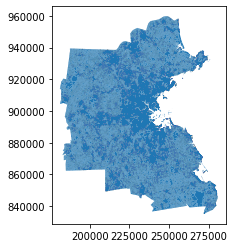

In [9]:
import matplotlib.pyplot as plt
data_common.shape
data_common.plot()
data_common.show()

In [17]:
data_common['owner_zip'].value_counts()

02360         19026
02780         14383
02155         14024
01960         13998
02301         13326
02703         12620
02184         12408
02169         11870
01810         11432
01915         11264
02151         11140
01701         11120
01760         11032
01801         10952
02148         10652
01826          9705
01876          9624
01906          9613
02038          9499
02132          9338
01752          9310
02186          9226
02302          9090
01930          9086
01824          8986
02072          8873
01887          8761
01880          8616
02176          8514
01757          8450
              ...  
02127-1881        1
77520             1
01930-1555        1
01945-2955        1
94621             1
01851 4930        1
02052-3344        1
30180             1
02301-4317        1
02302-1837        1
91911             1
02563-0308        1
02050-1766        1
01834-1425        1
30075-6810        1
01821-5180        1
01876-1639        1
28465             1
10282-2102        1


In [25]:
data_1=data_common[data_common['owner_zip']=="02446"]

In [26]:
data_1

,objectid,mapc_id,muni_id,muni,parloc_id,poly_typ,map_num,mappar_id,loc_id_cnt,land_value,...,bldgv_psf,totv_pac,bldlnd_rat,sqm_imperv,sqm_bldg,sqm_pave,realesttyp,temp,shape,geometry
14115,29906,51979,16,Attleboro,M_217930_853428,FEE,45,45_288,1.0,150000.0,...,126.752833,3.549795e+05,4.878000,1394.845757,401.682990,993.162767,0,NaN,590000000A000000080010006A69000081012000010000...,"POLYGON ((217964.129 853477.939, 217961.785 85..."
18822,34636,56709,16,Attleboro,M_211171_851138,TAX,6,None,1.0,180000.0,...,86.013986,2.515122e+06,4.236667,817.125953,314.539593,502.586360,0,NaN,6A0000000D000000080010006A69000092013B00010000...,"POLYGON ((211205.843 851152.039, 211208.733 85..."
20656,36470,58543,16,Attleboro,M_217838_854472,TAX,32,None,1.0,100500.0,...,20.658053,7.459749e+05,1.368159,483.627386,189.809569,293.817818,3,NaN,5C0000000B000000080010006A69000084013B00010000...,"POLYGON ((217859.912 854502.974, 217859.531 85..."
37172,53007,111638,26,Belmont,F_742364_2966469,FEE,26,26-89,1.0,370000.0,...,170.666667,6.591437e+06,1.037838,216.650356,131.587392,85.062964,2,NaN,4800000007000000080010006A69000030022100010000...,"POLYGON ((226290.002 904179.547, 226281.625 90..."
38962,54787,113418,26,Belmont,F_744746_2965129,FEE,6,6-13,1.0,560000.0,...,115.646259,7.308872e+06,0.650000,365.029912,175.284634,189.745278,2,NaN,3C00000005000000080010006A69000024012100010000...,"POLYGON ((227015.148 903767.978, 226988.052 90..."
39707,55526,114157,26,Belmont,F_745299_2964215,FEE,5,5-17,1.0,594000.0,...,137.767221,5.528506e+06,0.703704,360.276259,239.287350,120.988909,2,NaN,670000000E000000080010006A6900008F012100010000...,"POLYGON ((227167.321 903503.874, 227187.552 90..."
50964,66731,128224,30,Beverly,F_844047_3033586,FEE,63,63-20,1.0,263700.0,...,-0.999900,5.731543e+04,0.000000,597.951135,-0.999900,0.000000,2,NaN,FC00000025000000080010006A690000A4031300010000...,"POLYGON ((257286.811 924708.277, 257288.284 92..."
71217,87017,160040,51,Carlisle,F_690494_3013862,FEE,7,7-18-1,2.0,340700.0,...,65.689981,1.199929e+05,0.432345,764.301624,227.095762,537.205861,1,NaN,C50000001F000000080010006A690000AD021601010000...,"POLYGON ((210570.130 918624.073, 210568.120 91..."
71606,87407,160430,51,Carlisle,F_696037_3017521,FEE,15,15-39-B,1.0,313300.0,...,-0.999900,2.033413e+05,0.000000,-0.999900,-0.999900,0.000000,2,NaN,5400000009000000080010006A6900003C011601010000...,"POLYGON ((212087.171 919703.798, 212149.440 91..."
73174,88977,168309,57,Chelsea,F_782852_2966779,FEE,13,13-31,1.0,203400.0,...,53.412557,5.703552e+06,2.499017,504.974362,211.687776,293.286587,3,NaN,4800000007000000080010006A69000030011601010000...,"POLYGON ((238617.345 904290.367, 238624.597 90..."


In [27]:
import shapely.geometry
from shapely.geometry import shape

In [28]:
data_1_shape = shapely.geometry.shape(data_1["geometry"])

ValueError: Unknown geometry type: featurecollection

In [29]:
point = shapely.geometry.Point(46.362914,-63.503809) # longitude, latitude
if shape.contains(point):
    print("Found shape for point.")
else:
    print ("Not in the shape")

AttributeError: 'function' object has no attribute 'contains'

In [16]:
from shapely.geometry import Polygon
p1 = Polygon([(0,0), (1,1), (1,0)])
p2 = Polygon([(0,1), (1,0), (1,1)])
print(p1.intersects(p2))

True


In [ ]:
for i in range(0,10):
    for j in range (1,10):
        p1=data_common[]

In [ ]:
# Coordinate distance calculator, feed in the two pairs of latitudes and longitudes def haversine(row):     lon1 = row['Matching_Lon']     lat1 = row['Matching_Lat']     lon2 = row['longitude']     lat2 = row['latitude']     lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])     dlon = lon2 - lon1      dlat = lat2 - lat1      a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2     c = 2 * arcsin(sqrt(a))      km = 6367 * c     return km 

In [ ]:
### String Base:







### Shape File:
def word_diff(s1,s2):
    if 
